In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import librosa
import librosa.display
import os
import torch
from torch.utils.data import Dataset, DataLoader
import random
import skimage.io as io
import pandas as pd
import torchvision.models as models
from tqdm import tqdm

In [2]:
!pip install efficientnet_pytorch
from efficientnet_pytorch import EfficientNet

  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.0-py3-none-any.whl size=16033 sha256=677d3daec65b2a70c8591b35024ac4bef6398e72344a8d49ffc110a9b2160673
  Stored in directory: /root/.cache/pip/wheels/b7/cc/0d/41d384b0071c6f46e542aded5f8571700ace4f1eb3f1591c29
Successfully built efficientnet-pytorch


In [3]:
def seed_everything(seed=42):
    print(f'setting everything to seed {seed}')
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.cuda.empty_cache()
    
seed_everything(42)

setting everything to seed 42


In [4]:
device = torch.device('cuda:0')

In [5]:
data_dir = '//kaggle/input/heartbeat-sounds/set_b'
file_csv = '/kaggle/input/heartbeat-sounds/set_b.csv'

In [6]:
def mono_to_color(X, eps=1e-6, mean=None, std=None):
    X = np.stack([X, X, X])

    # Standardize
    mean = mean or X.mean()
    std = std or X.std()
    X = (X - mean) / (std + eps)

    # Normalize to [0, 255]
    _min, _max = X.min(), X.max()

    if (_max - _min) > eps:
        V = np.clip(X, _min, _max)
        V = 255 * (V - _min) / (_max - _min)
        V = V.astype(np.uint8)
    else:
        V = np.zeros_like(X, dtype=np.uint8)

    return V


def normalize(image, mean=None, std=None):
    image = image / 255.0
    if mean is not None and std is not None:
        image = (image - mean) / std
    return image.astype(np.float32)

In [7]:
NUM_SAMPLES = 65500
sr = 48000
fmin = 84
fmax = sr // 2
nmels = 128

In [8]:
recordings_old = sorted(os.listdir(data_dir))

In [9]:
recordings = []
i = 0
for x in recordings_old:
    if i % 50 == 0:
        print(i)
    i += 1
    y, _ = librosa.load(data_dir + '/' + x, sr = sr)
    if y.shape[0] >= NUM_SAMPLES:
        recordings.append(x)

0
50
100
150
200
250
300
350
400
450
500
550
600
650


In [10]:
len(recordings)

638

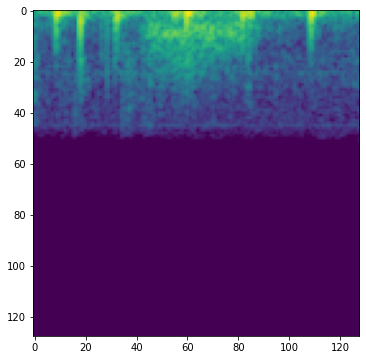

In [11]:
y, _ = librosa.load(data_dir + '/' + recordings[200], sr = sr)
begin = (len(y) - NUM_SAMPLES) // 2
samples = y[begin:begin + NUM_SAMPLES]
melspec = librosa.feature.melspectrogram(samples, sr=sr, n_mels = nmels)#, fmin=fmin, fmax=fmax)
melspec = librosa.power_to_db(melspec)
melspec = mono_to_color(melspec)
melspec = normalize(melspec, mean=None, std=None)
#melspec = self.img_transform(image=melspec)['image']
plt.figure(figsize = (20, 6))
plt.imshow(melspec[0])

In [12]:
image_size = melspec.shape
image_size

(3, 128, 128)

In [13]:
def get_spectrograms(filename):
    y, _ = librosa.load(filename, sr = sr)
    count = len(y) // NUM_SAMPLES
    mel_spectrograms = []
    for i in range(count):
        samples = y[i * NUM_SAMPLES:(i + 1) * NUM_SAMPLES]
        melspec = librosa.feature.melspectrogram(samples, sr=sr, n_mels=nmels, fmin=fmin, fmax=fmax)
        melspec = librosa.power_to_db(melspec)
        melspec = mono_to_color(melspec)
        melspec = normalize(melspec, mean=None, std=None)
        #melspec = self.img_transform(image=melspec)['image']
        mel_spectrograms.append(torch.tensor(melspec, dtype=torch.float32))

    return mel_spectrograms, count

In [14]:
class HeartbeatSounds(Dataset):
    def __init__(self, mode = 'train', data_dir='./', train_size=0.8, random_seed=42, recordings=[]):
        super().__init__()
        data = []
        labels = []
        for i in range(len(recordings)):
            #print(recordings[i])
            if 'normal' in recordings[i]:
                label = 0
                mel_spectrograms, count = get_spectrograms(data_dir + '/' + recordings[i])
                for j in range(count):
                    data.append(mel_spectrograms[j])
                    labels.append(label)
            elif 'extrastole' in recordings[i]:
                label = 1
                mel_spectrograms, count = get_spectrograms(data_dir + '/' + recordings[i])
                for j in range(count):
                    data.append(mel_spectrograms[j])
                    labels.append(label)
            elif 'murmur' in recordings[i]:
                label = 2
                mel_spectrograms, count = get_spectrograms(data_dir + '/' + recordings[i])
                for j in range(count):
                    data.append(mel_spectrograms[j])
                    labels.append(label)
        
        keys = np.arange(len(data))
        train_keys, test_keys = train_test_split(keys, train_size=train_size, random_state=random_seed)
        if mode == 'train':
            keys = train_keys
        else:
            keys = test_keys
        self.n = len(keys)
        self.data = []
        self.labels = []
        for i in keys:
            #print(recordings[i])
            self.data.append(data[i])
            self.labels.append(labels[i])
        

    def __getitem__(self, i):     
        return self.data[i], self.labels[i]

    def __len__(self):
        return self.n

In [15]:
train_dataset = HeartbeatSounds(mode='train', data_dir=data_dir, recordings=recordings)
test_dataset = HeartbeatSounds(mode='test', data_dir=data_dir, recordings=recordings)

In [16]:
len(train_dataset)

1574

In [17]:
batch_size = 32

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [18]:
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [19]:
max_epoch = 50
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [20]:
for epoch in range(max_epoch):
    print('epoch:', epoch)
    model.train()
    #all_ys = []
    #all_preds = []
    sum_loss = 0
    #sum_accuracy = 0
    cnt_objects = 0
    for X, y in train_dataloader:
        optimizer.zero_grad()
        X = X.to(device)
        scores = model(X)
        loss = criterion(scores, y.to(device))
        loss.backward()
        optimizer.step()
        sum_loss += float(loss) * len(y)
        cnt_objects += len(y)

        #all_ys.append(y)
        #all_preds.append(preds)
    mean_loss = sum_loss / cnt_objects
    print('Train')
    print(mean_loss)
    
    model.eval()
    #all_ys = []
    #all_preds = []
    sum_loss = 0
    sum_accuracy = 0
    cnt_objects = 0
    with torch.no_grad():
        for X, y in test_dataloader:
            X = X.to(device)
            scores = model(X)
            loss = criterion(scores, y.to(device))
            sum_loss += float(loss) * len(y)
            preds = scores.cpu().detach().argmax(dim=1)
            accuracy = (y == preds).float().sum()
            sum_accuracy += accuracy
            cnt_objects += len(y)

            #all_ys.append(y)
            #all_preds.append(preds)

    print('TEST')
    mean_loss = sum_loss / cnt_objects
    mean_accuracy = sum_accuracy / cnt_objects
    print('loss:', mean_loss)
    print('accuracy:', mean_accuracy)
    print('******************')

epoch: 0
Train
0.7528373316933875
TEST
loss: 0.738132866506044
accuracy: tensor(0.6954)
******************
epoch: 1
Train
0.5230781816163844
TEST
loss: 0.4886498505694007
accuracy: tensor(0.7843)
******************
epoch: 2
Train
0.5082965370509039
TEST
loss: 0.5676063414152503
accuracy: tensor(0.7919)
******************
epoch: 3
Train
0.4657409932970849
TEST
loss: 0.4938127159467203
accuracy: tensor(0.8198)
******************
epoch: 4
Train
0.41239264849786383
TEST
loss: 0.46577169991991846
accuracy: tensor(0.8096)
******************
epoch: 5
Train
0.3818285185772703
TEST
loss: 0.710356961652107
accuracy: tensor(0.7741)
******************
epoch: 6
Train
0.33452057111369304
TEST
loss: 0.48091313379065037
accuracy: tensor(0.8020)
******************
epoch: 7
Train
0.26956378372227524
TEST
loss: 0.6253863518613244
accuracy: tensor(0.7843)
******************
epoch: 8
Train
0.2682498273885841
TEST
loss: 1.0622168458657821
accuracy: tensor(0.6701)
******************
epoch: 9
Train
0.36321313